In [83]:
import sklearn
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_point, labs, facet_wrap, geom_abline
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score

In [84]:
data = pd.read_csv("Data/Hitters.csv")


In [85]:
data.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [86]:
data = data.dropna()

In [87]:
data.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague'],
      dtype='object')

## PART 1

In [88]:
X = data.drop(columns=["Salary"])
y = data["Salary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [89]:
ct = ColumnTransformer(
    transformers=[
        ("select", StandardScaler(), ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits',
       'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts',
       'Assists', 'Errors']),
        ("dummify", OneHotEncoder(sparse_output = False, handle_unknown="ignore"), ["League",'Division','NewLeague'])

    ],
    remainder = "passthrough"
).set_output(transform = "pandas")

A. Regression without regularization

In [90]:
pipe_1 = Pipeline([
    ("prepocessing", ct),
    ("linereg", LinearRegression())
])

pipe_1_fitted = pipe_1.fit(X,y)


feature_names = pipe_1_fitted.named_steps['prepocessing'].get_feature_names_out()
pipe_1_fitted_coefs = pipe_1_fitted.named_steps['linereg'].coef_
coef_df_pipe_1 = pd.DataFrame({
    "Feature": feature_names,
    "Coef":pipe_1_fitted_coefs })

coef_df_pipe_1.sort_values(by='Coef', ascending=False)



,Feature,Coef
10,select__CRuns,480.747135
1,select__Hits,337.830479
11,select__CRBI,260.689886
5,select__Walks,135.073897
8,select__CHits,86.687617
13,select__PutOuts,78.761296
18,dummify__Division_E,58.424623
14,select__Assists,53.732490
2,select__HmRun,37.853837
17,dummify__League_N,31.299712


2. interpret a few of the most important coefficients:
In the model Career Runs has the most impact on salary, for every 1 run increase in a players career their salary increases by 480 thousand dollars. This makes as players who have played more likely have bigger contracts and have scored more runs. Also the highest paid guys likely score a lot. Hit and RBIs also increase salary by a lot in this model which shows success at the plate leads to higher salaries. 

In [91]:
pipe_1_MSE = cross_val_score(pipe_1, X, y, cv=5, scoring='neg_mean_squared_error')
pipe_1_mse_scores = -pipe_1_MSE
pipe_1_mse_scores.mean()

np.float64(121136.31031816891)

3. MSE = 121136.31031816891

B. Ridge regression

In [92]:
pipe_2 = Pipeline([
    ("prepocessing", ct),
    ("ridgereg", Ridge())
]).set_output(transform="pandas")

alphas = {'ridgereg__alpha': [0.001,0.01,0.1,1,10]}

gscv_ridge = GridSearchCV(pipe_2, alphas, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted_ridge = gscv_ridge.fit(X, y)

gscv_fitted_ridge.cv_results_['mean_test_score']
df_ridge= pd.DataFrame(gscv_fitted_ridge.cv_results_)

ridge_results = df_ridge[['param_ridgereg__alpha', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)
ridge_results


,param_ridgereg__alpha,mean_test_score
3,1.000,-119144.432677
4,10.000,-119348.984776
2,0.100,-120343.621067
1,0.010,-121022.903286
0,0.001,-121124.458592


In [93]:
best_pipe_ridge = Pipeline([
    ("prepocessing", ct),
    ("ridgereg", Ridge(alpha=1))
]).set_output(transform="pandas")

best_fitted_ridge = best_pipe_ridge.fit(X, y)

feature_names = best_fitted_ridge.named_steps['prepocessing'].get_feature_names_out()
ridge_fitted_coefs = best_fitted_ridge.named_steps['ridgereg'].coef_
coef_df_ridge = pd.DataFrame({
    "Feature": feature_names,
    "Coef":ridge_fitted_coefs })

coef_df_ridge.sort_values(by='Coef', ascending=False)

,Feature,Coef
10,select__CRuns,320.412169
1,select__Hits,296.645050
11,select__CRBI,160.386784
8,select__CHits,126.659607
5,select__Walks,124.407173
13,select__PutOuts,78.623656
18,dummify__Division_E,60.015595
14,select__Assists,47.462597
9,select__CHmRun,39.070924
17,dummify__League_N,30.438855


3. The Ridge coefficients show that long-term offensive production (CRuns, Hits, CRBIs) is most strongly associated with salary. Because Ridge keeps correlated predictors in the model instead of dropping them, it spreads influence across this group but still highlights which variables matter most. 1 unit increase in CRuns increases salary by 320 thousand dollars and for hits 296 thousand dollars.

4. MSE = 119144.432677

C. Lasso Regression

In [94]:
lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso())]
).set_output(transform="pandas")

alphas = {'lasso_regression__alpha': [0.001,0.01,0.1,1,10]}


gscv_lasso = GridSearchCV(lasso_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted_lasso = gscv_lasso.fit(X, y)

gscv_fitted_lasso.cv_results_['mean_test_score']
df_lasso= pd.DataFrame(gscv_fitted_lasso.cv_results_)

lasso_results = df_lasso[['param_lasso_regression__alpha', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)
lasso_results

C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.004e+07, tolerance: 4.708e+03
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.983e+06, tolerance: 3.606e+03
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.012e+07, tolerance: 4.137e+03
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

,param_lasso_regression__alpha,mean_test_score
3,1.000,-119761.628313
2,0.100,-120682.219611
1,0.010,-120964.767703
0,0.001,-120994.180175
4,10.000,-121828.102220


In [95]:
best_lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(alpha=1))]
).set_output(transform="pandas")

best_fitted_lasso = best_lasso_pipeline.fit(X, y)

feature_names = best_fitted_lasso.named_steps['preprocessing'].get_feature_names_out()
lasso_fitted_coefs = best_fitted_lasso.named_steps['lasso_regression'].coef_
coef_df_lasso = pd.DataFrame({
    "Feature": feature_names,
    "Coef":lasso_fitted_coefs })

coef_df_lasso.sort_values(by='Coef', ascending=False)

,Feature,Coef
10,select__CRuns,3.755650e+02
1,select__Hits,3.043583e+02
11,select__CRBI,1.926164e+02
5,select__Walks,1.206948e+02
18,dummify__Division_E,1.144130e+02
13,select__PutOuts,7.876026e+01
14,select__Assists,4.199666e+01
9,select__CHmRun,1.422286e+01
2,select__HmRun,1.112715e+01
17,dummify__League_N,1.908192e-14


4. CRuns still is the largest postive coefficient with one unit increase rsulting in salary increase of 3.755650e+02. RBI , CHit, and some league variables were set to 0. This is because LASSO makes many weaker or redundant predictors, such as categorical indicators or highly correlated batting stats, set to exactly zero

4. MSE = 119761.628313

D. Elastic Net

In [96]:
elastic_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elasticnet_regression", ElasticNet())]
).set_output(transform="pandas")

elastic_param_grid = {'elasticnet_regression__alpha': [0.001,0.01,0.1,1,10],
'elasticnet_regression__l1_ratio': [0.1,0.25,0.5,0.75,0.9]} 


gscv_elastic = GridSearchCV(elastic_pipeline, elastic_param_grid, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted_elastic = gscv_elastic.fit(X, y)

gscv_fitted_elastic.cv_results_['mean_test_score']
df_elastic= pd.DataFrame(gscv_fitted_elastic.cv_results_)

elastic_results = df_elastic[['param_elasticnet_regression__alpha','param_elasticnet_regression__l1_ratio', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)
elastic_results

C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.033e+07, tolerance: 4.708e+03
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.137e+06, tolerance: 3.606e+03
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.030e+07, tolerance: 4.137e+03
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

,param_elasticnet_regression__alpha,param_elasticnet_regression__l1_ratio,mean_test_score
14,0.100,0.90,-118969.491456
5,0.010,0.10,-118973.789406
6,0.010,0.25,-119009.799631
13,0.100,0.75,-119036.415623
7,0.010,0.50,-119123.789921
12,0.100,0.50,-119381.375758
8,0.010,0.75,-119404.656366
11,0.100,0.25,-119636.170153
10,0.100,0.10,-119745.310236
19,1.000,0.90,-119856.902065


In [97]:
best_elastic_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elasticnet_regression", ElasticNet(alpha=0.1,l1_ratio=0.9))]
).set_output(transform="pandas")

best_fitted_elastic = best_elastic_pipeline.fit(X, y)

feature_names = best_fitted_elastic.named_steps['preprocessing'].get_feature_names_out()
elastic_fitted_coefs = best_fitted_elastic.named_steps['elasticnet_regression'].coef_
coef_df_elastic = pd.DataFrame({
    "Feature": feature_names,
    "Coef":elastic_fitted_coefs })

coef_df_elastic.sort_values(by='Coef', ascending=False)

,Feature,Coef
1,select__Hits,247.556168
10,select__CRuns,223.037799
11,select__CRBI,121.693876
8,select__CHits,120.015087
5,select__Walks,110.808219
13,select__PutOuts,77.918536
18,dummify__Division_E,60.670585
9,select__CHmRun,55.914795
14,select__Assists,40.736641
17,dummify__League_N,27.879970


3. Hits is the strongest predictor in the Elastic Net model. A one-SD increase in career hits is associated with about $248k more salary. This indicates that overall hitting consistency is a major factor in determining player pay. Career Runs has the second-largest coefficient. This means players who have scored more runs over their careers tend to earn significantly higher salaries, even after controlling for other batting stats.

4. MSE = 118969.491456

## PART 2 

Based on the results above, the most important numeric variable is CRuns, the fice most important are CRuns, Hits, CRBI, CHits, and Walks the most important categorical variable is Division E. 

In [98]:
ct_single_num_var = ColumnTransformer(
    transformers=[
        ("select", StandardScaler(), ['CRuns']),
    ],
    remainder = "drop"
).set_output(transform = "pandas")

pipe_1_sing_var = Pipeline([
    ("prepocessing", ct_single_num_var),
    ("linereg", LinearRegression())
])

pipe_1_sing_var_fitted = pipe_1_sing_var.fit(X,y)

pipe_2 = Pipeline([
    ("prepocessing", ct_single_num_var),
    ("ridgereg", Ridge())
]).set_output(transform="pandas")

alphas = {'ridgereg__alpha': [0.001,0.01,0.1,1,10]}

gscv_ridge = GridSearchCV(pipe_2, alphas, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted_ridge = gscv_ridge.fit(X, y)

lasso_pipeline = Pipeline(
  [("preprocessing", ct_single_num_var),
  ("lasso_regression", Lasso())]
).set_output(transform="pandas")

alphas = {'lasso_regression__alpha': [0.001,0.01,0.1,1,10]}


gscv_lasso = GridSearchCV(lasso_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted_lasso = gscv_lasso.fit(X, y)

elastic_pipeline = Pipeline(
  [("preprocessing", ct_single_num_var),
  ("elasticnet_regression", ElasticNet())]
).set_output(transform="pandas")

elastic_param_grid = {'elasticnet_regression__alpha': [0.001,0.01,0.1,1,10],
'elasticnet_regression__l1_ratio': [0.1,0.25,0.5,0.75,0.9]} 


gscv_elastic = GridSearchCV(elastic_pipeline, elastic_param_grid, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted_elastic = gscv_elastic.fit(X, y)



In [99]:
ols_cv_mse = -cross_val_score(pipe_1_sing_var, X, y, cv=5,
                              scoring='neg_mean_squared_error').mean()

best_alpha_ridge = gscv_fitted_ridge.best_params_['ridgereg__alpha']
ridge_cv_mse = -gscv_fitted_ridge.best_score_

best_alpha_lasso = gscv_fitted_lasso.best_params_['lasso_regression__alpha']
lasso_cv_mse = -gscv_fitted_lasso.best_score_

best_alpha_en = gscv_fitted_elastic.best_params_['elasticnet_regression__alpha']
best_l1_en = gscv_fitted_elastic.best_params_['elasticnet_regression__l1_ratio']
en_cv_mse = -gscv_fitted_elastic.best_score_

summary = pd.DataFrame({
    'Model': ['OLS (single var)', 'Ridge (single var)', 'LASSO (single var)', 'Elastic Net (single var)'],
    'Best alpha': [None, best_alpha_ridge, best_alpha_lasso, best_alpha_en],
    'Best l1_ratio': [None, None, None, best_l1_en],
    'CV MSE': [ols_cv_mse, ridge_cv_mse, lasso_cv_mse, en_cv_mse]
})
summary

,Model,Best alpha,Best l1_ratio,CV MSE
0,OLS (single var),NaN,NaN,143812.935916
1,Ridge (single var),10.0,NaN,143658.517369
2,LASSO (single var),10.0,NaN,143793.449159
3,Elastic Net (single var),0.1,0.5,143655.076048


In [100]:
ct_top5_num_var = ColumnTransformer(
    transformers=[
        ("select", StandardScaler(), ['CRuns', 'Hits', 'CRBI', 'CHits','Walks']),
    ],
    remainder = "drop"
).set_output(transform = "pandas")

pipe_1_top5_var = Pipeline([
    ("prepocessing", ct_top5_num_var),
    ("linereg", LinearRegression())
])

pipe_1_top5_fitted = pipe_1_top5_var.fit(X,y)

pipe_2 = Pipeline([
    ("prepocessing", ct_top5_num_var),
    ("ridgereg", Ridge())
]).set_output(transform="pandas")

alphas = {'ridgereg__alpha': [0.001,0.01,0.1,1,10]}

gscv_ridge = GridSearchCV(pipe_2, alphas, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted_ridge = gscv_ridge.fit(X, y)

lasso_pipeline = Pipeline(
  [("preprocessing", ct_top5_num_var),
  ("lasso_regression", Lasso())]
).set_output(transform="pandas")

alphas = {'lasso_regression__alpha': [0.001,0.01,0.1,1,10]}


gscv_lasso = GridSearchCV(lasso_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted_lasso = gscv_lasso.fit(X, y)

elastic_pipeline = Pipeline(
  [("preprocessing", ct_top5_num_var),
  ("elasticnet_regression", ElasticNet())]
).set_output(transform="pandas")

elastic_param_grid = {'elasticnet_regression__alpha': [0.001,0.01,0.1,1,10],
'elasticnet_regression__l1_ratio': [0.1,0.25,0.5,0.75,0.9]} 


gscv_elastic = GridSearchCV(elastic_pipeline, elastic_param_grid, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted_elastic = gscv_elastic.fit(X, y)

In [101]:
ols_cv_mse = -cross_val_score(pipe_1_top5_var, X, y, cv=5,
                              scoring='neg_mean_squared_error').mean()

best_alpha_ridge = gscv_fitted_ridge.best_params_['ridgereg__alpha']
ridge_cv_mse = -gscv_fitted_ridge.best_score_

best_alpha_lasso = gscv_fitted_lasso.best_params_['lasso_regression__alpha']
lasso_cv_mse = -gscv_fitted_lasso.best_score_

best_alpha_en = gscv_fitted_elastic.best_params_['elasticnet_regression__alpha']
best_l1_en = gscv_fitted_elastic.best_params_['elasticnet_regression__l1_ratio']
en_cv_mse = -gscv_fitted_elastic.best_score_

summary = pd.DataFrame({
    'Model': ['OLS (top 5 var)', 'Ridge (top 5 var)', 'LASSO (top 5 var)', 'Elastic Net (top 5 var)'],
    'Best alpha': [None, best_alpha_ridge, best_alpha_lasso, best_alpha_en],
    'Best l1_ratio': [None, None, None, best_l1_en],
    'CV MSE': [ols_cv_mse, ridge_cv_mse, lasso_cv_mse, en_cv_mse]
})
summary

,Model,Best alpha,Best l1_ratio,CV MSE
0,OLS (top 5 var),NaN,NaN,126047.770851
1,Ridge (top 5 var),10.0,NaN,123172.832275
2,LASSO (top 5 var),10.0,NaN,124607.123928
3,Elastic Net (top 5 var),1.0,0.75,122077.244186


In [102]:
X["Division_E"] = (X["Division"] == "E").astype(int)

ct_top5_interact = ColumnTransformer(
    transformers=[
        ("select", StandardScaler(), ['CRuns', 'Hits', 'CRBI', 'CHits','Walks']),
        ("dummify", OneHotEncoder(sparse_output = False, handle_unknown="ignore"), ['Division']),
        ("interaction1", PolynomialFeatures(interaction_only = True), ["CRuns", "Division_E"]),
        ("interaction2", PolynomialFeatures(interaction_only = True), ["Hits", "Division_E"]),
        ("interaction3", PolynomialFeatures(interaction_only = True), ["CRBI", "Division_E"]),
        ("interaction4", PolynomialFeatures(interaction_only = True), ["CHits", "Division_E"]),
        ("interaction5", PolynomialFeatures(interaction_only = True), ["Walks", "Division_E"]),
    ],
    remainder = "drop"
).set_output(transform = "pandas")

pipe_1_top5_interact = Pipeline([
    ("prepocessing", ct_top5_interact),
    ("linereg", LinearRegression())
])

pipe_1_top5_interact_fitted = pipe_1_top5_interact.fit(X,y)

pipe_2 = Pipeline([
    ("prepocessing", ct_top5_interact),
    ("ridgereg", Ridge())
]).set_output(transform="pandas")

alphas = {'ridgereg__alpha': [0.001,0.01,0.1,1,10]}

gscv_ridge = GridSearchCV(pipe_2, alphas, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted_ridge = gscv_ridge.fit(X, y)

lasso_pipeline = Pipeline(
  [("preprocessing", ct_top5_interact),
  ("lasso_regression", Lasso())]
).set_output(transform="pandas")

alphas = {'lasso_regression__alpha': [0.001,0.01,0.1,1,10]}


gscv_lasso = GridSearchCV(lasso_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted_lasso = gscv_lasso.fit(X, y)

elastic_pipeline = Pipeline(
  [("preprocessing", ct_top5_interact),
  ("elasticnet_regression", ElasticNet())]
).set_output(transform="pandas")

elastic_param_grid = {'elasticnet_regression__alpha': [0.001,0.01,0.1,1,10],
'elasticnet_regression__l1_ratio': [0.1,0.25,0.5,0.75,0.9]} 


gscv_elastic = GridSearchCV(elastic_pipeline, elastic_param_grid, cv = 5, scoring='neg_mean_squared_error')
gscv_fitted_elastic = gscv_elastic.fit(X, y)


C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.184e+07, tolerance: 4.708e+03
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.426e+06, tolerance: 3.606e+03
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.159e+07, tolerance: 4.137e+03
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

In [103]:
ols_cv_mse = -cross_val_score(pipe_1_top5_interact_fitted, X, y, cv=5,
                              scoring='neg_mean_squared_error').mean()

best_alpha_ridge = gscv_fitted_ridge.best_params_['ridgereg__alpha']
ridge_cv_mse = -gscv_fitted_ridge.best_score_

best_alpha_lasso = gscv_fitted_lasso.best_params_['lasso_regression__alpha']
lasso_cv_mse = -gscv_fitted_lasso.best_score_

best_alpha_en = gscv_fitted_elastic.best_params_['elasticnet_regression__alpha']
best_l1_en = gscv_fitted_elastic.best_params_['elasticnet_regression__l1_ratio']
en_cv_mse = -gscv_fitted_elastic.best_score_

summary = pd.DataFrame({
    'Model': ['OLS (top 5 with interaction var)', 'Ridge (top 5 with interaction var)', 'LASSO (top 5 with interaction var)', 'Elastic Net (top 5 with interaction var)'],
    'Best alpha': [None, best_alpha_ridge, best_alpha_lasso, best_alpha_en],
    'Best l1_ratio': [None, None, None, best_l1_en],
    'CV MSE': [ols_cv_mse, ridge_cv_mse, lasso_cv_mse, en_cv_mse]
})
summary

,Model,Best alpha,Best l1_ratio,CV MSE
0,OLS (top 5 with interaction var),NaN,NaN,134896.044267
1,Ridge (top 5 with interaction var),10.0,NaN,134542.776381
2,LASSO (top 5 with interaction var),10.0,NaN,132777.730262
3,Elastic Net (top 5 with interaction var),10.0,0.1,132655.236504


Report which combination of features and model performed best, based on the validation metric of MSE.

Elastic Net with just the top 5 varibales with an alpha of 1.0 and an l1_ratio of 0.75 has the lowest MSE of all the models with 122077.244186

## Part III. Discussion

A. Ridge

Ridge performed much better (best MSE around 119,144) with alpha = 1. Ridge shrinks coefficients but never forces them to zero. In my results, important variables like CRuns, Hits, CRBI, Walks, PutOuts still had relatively large coefficients, but noticeably smaller than in linear regression. This means Ridge reduced overfitting by damping noisy variables without removing them entirely.

B. LASSO

When I compared the LASSO model from Part I to the three LASSO models in Part II, the lambda values were not the same, and the MSE values were also different. This outcome is fully expected because the models are not using the same predictors and LASSO’s optimal lambda depends on the feature set being used. LASSO’s performance depends directly on the available predictors, so each model’s CV MSE reflects how much information those predictors carry. More informative features leads to  better MSE. Simplified subsets leads to worse MSE

C. Elastic Net

Ridge cannot zero out coefficients. LASSO can zero out too many coefficients when predictors are correlated. Elastic Net balances both penalties and avoids the weaknesses of each individual method. Elastic Net has two tuning parameters instead of one, so it has more flexibility to adapt to the structure of the data. The extra flexibility allows it to keep important variables (like Ridge), remove unneeded ones (like LASSO), and shrink correlated groups of predictors together. All of this leads to consistently lower cross-validated MSE.

## Part IV: Final Model

In [104]:
elastic_pipeline = Pipeline(
  [("preprocessing", ct_top5_num_var),
  ("elasticnet_regression", ElasticNet(alpha=1,l1_ratio=0.75))]
).set_output(transform="pandas")

gscv_fitted_elastic = elastic_pipeline.fit(X, y)

feature_names = elastic_pipeline.named_steps["preprocessing"].get_feature_names_out()
coefs = elastic_pipeline.named_steps["elasticnet_regression"].coef_

coef_df_elasic = pd.DataFrame({
    "Feature": feature_names,
    "Coef": coefs })

coef_df_elasic.sort_values(by='Coef', ascending=False)


,Feature,Coef
1,select__Hits,88.560103
2,select__CRBI,83.958757
4,select__Walks,68.781442
0,select__CRuns,60.653269
3,select__CHits,54.162506


In [105]:
cv_mse = -cross_val_score(elastic_pipeline, X, y, cv=5,
                          scoring='neg_mean_squared_error').mean()
print(cv_mse)


122077.24418555049


The best-performing model was the Elastic Net model using only the Top 5 numeric predictors, with a cross-validated MSE of 122,077.24. This model outperformed both Ridge and LASSO because the Elastic Net penalty balances the benefits of both methods: Ridge’s stability with correlated predictors and LASSO’s ability to shrink weaker variables.

I refit this final Elastic Net pipeline on the full Hitters dataset using the optimal hyperparameters from the grid search. The fitted model shows that the five key career totals, CRuns, Hits, CRBI, CHits, and Walks, remain the strongest predictors of player salary. The model’s predictions track the observed salaries closely, indicating good overall fit without excessive overfitting.

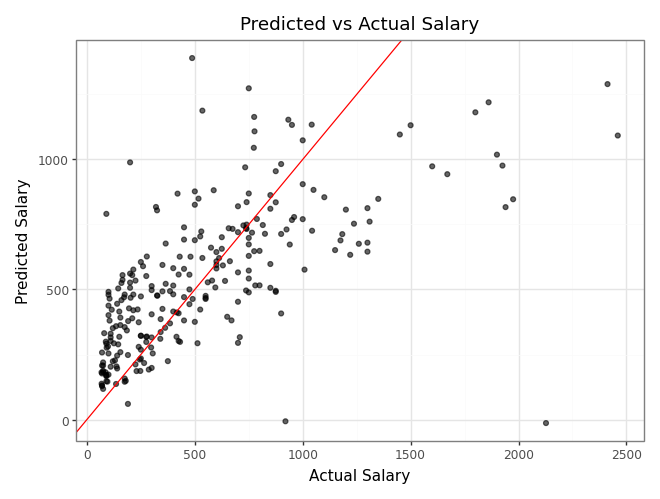

In [106]:
from plotnine import *

best_model = gscv_fitted_elastic
y_hat = best_model.predict(X)

df_plot = pd.DataFrame({
    "Actual": y,
    "Predicted": y_hat
})

# plotnine plot
(
    ggplot(df_plot, aes(x='Actual', y='Predicted')) +
    geom_point(alpha=0.6) +
    geom_abline(intercept=0, slope=1, color='red') +
    labs(title="Predicted vs Actual Salary",
         x="Actual Salary",
         y="Predicted Salary") +
    theme_bw()
)
